In [1]:
!nvidia-smi

Sun Mar  7 15:25:48 2021       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 450.102.04   Driver Version: 450.102.04   CUDA Version: 11.0     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  TITAN X (Pascal)    Off  | 00000000:08:00.0 Off |                  N/A |
| 51%   79C    P0    89W / 250W |     15MiB / 12194MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [2]:
!pip install keras==2.4.3

In [3]:
import os

In [4]:
os.getcwd()

'/home/dhruv/soundHAR'

In [5]:
!nvcc -V

nvcc: NVIDIA (R) Cuda compiler driver
Copyright (c) 2005-2020 NVIDIA Corporation
Built on Wed_Jul_22_19:09:09_PDT_2020
Cuda compilation tools, release 11.0, V11.0.221
Build cuda_11.0_bu.TC445_37.28845127_0


In [46]:
import numpy as np
import vggish_params
import vggish_keras
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pickle
from sklearn.preprocessing import OneHotEncoder
from keras.layers import Dense
from keras.models import Model
from keras.optimizers import Adam
from keras.losses import CategoricalCrossentropy
from keras.metrics import Accuracy, Precision, Recall
from sklearn.utils import class_weight
from keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, f1_score, confusion_matrix
from statistics import mode
from tqdm import tqdm
import time
from keras.models import load_model

In [47]:
checkpoint_path = 'vggish_weights.ckpt'
# checkpoint_path = 'example_model.hdf5'

In [29]:
sfreq = 16000

In [42]:
MODEL_URL = "https://www.dropbox.com/s/cq1d7uqg0l28211/example_model.hdf5?dl=1"
MODEL_PATH = "example_model.hdf5"
wget.download(MODEL_URL,MODEL_PATH)

'example_model.hdf5'

In [40]:
import wget

In [37]:
features[0].shape

(16, 64, 21)

In [9]:
features = pickle.load(open('featurized_data/default_config/X_{}.pkl'.format(sfreq), 'rb'))
labels = pickle.load(open('featurized_data/default_config/y_{}.pkl'.format(sfreq), 'rb'))
features = np.concatenate(np.concatenate(features))
labels = np.concatenate(np.concatenate(labels))

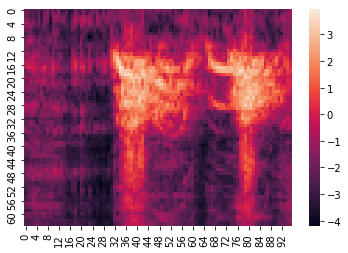

In [12]:
sns.heatmap(features[20000].T)

In [ ]:
# selected_labels = ['alarm-clock','buzzer', 'cough', 'dishwasher','doorbell',
#                    'gargle','shaver','toothbrush','typing','write']

In [ ]:
# features_s = []
# labels_s = []
# for label in selected_labels:
#     idx = np.where(labels == label)[0]
#     features_s.append(features[idx])
#     labels_s.append(labels[idx])

In [ ]:
# features_s = np.vstack(features_s)
# labels_s = np.concatenate(labels_s)

In [ ]:
# features = features_s
# labels = labels_s

In [13]:
weights = class_weight.compute_class_weight('balanced',
                                            np.unique(labels),
                                            labels)
class_weights = dict(enumerate(weights))
class_name_weights = {np.unique(labels)[key]:class_weights[key] for key in class_weights.keys()}
class_name_weights

/home/dhruv/anaconda3/lib/python3.8/site-packages/sklearn/utils/validation.py:68: FutureWarning: Pass classes=['alarm-clock' 'baby-cry' 'blender' 'car-horn' 'cat-meow' 'chopping'
 'cooking' 'cough' 'dishwasher' 'dog-bark' 'door' 'doorbell' 'drill'
 'engine' 'flush' 'hair-dryer' 'hammer' 'hazard-alarm' 'knock' 'laugh'
 'microwave' 'phone-ring' 'saw' 'shaver' 'snore' 'speech' 'toothbrush'
 'typing' 'vacuum' 'water-running'], y=['baby-cry' 'baby-cry' 'baby-cry' ... 'cat-meow' 'cat-meow' 'cat-meow'] as keyword args. From version 0.25 passing these as positional arguments will result in an error
  warnings.warn("Pass {} as keyword args. From version 0.25 "


{'alarm-clock': 2.60639923591213,
 'baby-cry': 1.4070121165248775,
 'blender': 3.4851851851851854,
 'car-horn': 7.725123849964614,
 'cat-meow': 7.611994421199442,
 'chopping': 3.275007500750075,
 'cooking': 1.0200542005420055,
 'cough': 4.59991571849979,
 'dishwasher': 1.3018008348240906,
 'dog-bark': 1.144552794379784,
 'door': 4.394363929146538,
 'doorbell': 9.073649210307565,
 'drill': 1.7950337115605985,
 'engine': 0.2725084881166367,
 'flush': 1.7211605171870072,
 'hair-dryer': 2.6195344372450204,
 'hammer': 1.3092959097996881,
 'hazard-alarm': 0.626253585771658,
 'knock': 5.739011566771819,
 'laugh': 2.451841868823001,
 'microwave': 1.4778770647170323,
 'phone-ring': 0.951748190775133,
 'saw': 2.0827323029956117,
 'shaver': 2.0013934726806015,
 'snore': 3.972197962154294,
 'speech': 0.15628096097127966,
 'toothbrush': 6.826516572858036,
 'typing': 0.9033101621979477,
 'vacuum': 0.6507839980921719,
 'water-running': 0.21761562998405104}

In [14]:
ohe = OneHotEncoder()
labels = ohe.fit_transform(labels.reshape((-1,1))).toarray()

NUM_CLASSES = len(weights)

features = features.reshape((-1, 
                             vggish_params.NUM_FRAMES, 
                             vggish_params.NUM_BANDS, 1))

labels = labels.reshape((-1, NUM_CLASSES))
X_train = features
y_train = labels
del features,labels

In [15]:
test_features = pickle.load(open('featurized_data/default_config/X_test_{}.pkl'.format(sfreq), 'rb'))
test_labels = pickle.load(open('featurized_data/default_config/y_test_{}.pkl'.format(sfreq), 'rb'))
test_features = np.concatenate(np.concatenate(test_features))
test_labels = np.concatenate(np.concatenate(test_labels))

test_labels = ohe.transform(test_labels.reshape((-1,1))).toarray()

# NUM_CLASSES = 30

test_features = test_features.reshape((-1, 
                             vggish_params.NUM_FRAMES, 
                             vggish_params.NUM_BANDS, 1))

test_labels = test_labels.reshape((-1, NUM_CLASSES))

In [16]:
X_test = test_features
y_test = test_labels
del test_labels, test_features

In [17]:
print('X train shape {}'.format(X_train.shape))
print('X test  shape {}'.format(X_test.shape))
print('y train shape {}'.format(y_train.shape))
print('y test  shape {}'.format(y_test.shape))

X train shape (109156, 96, 64, 1)
X test  shape (26154, 96, 64, 1)
y train shape (109156, 30)
y test  shape (26154, 30)


In [18]:
# Define VGGish, load the checkpoint, and run the batch through the model to
# produce embeddings.
vggish = vggish_keras.get_vggish_keras(use_with_lstm=False)
vggish.load_weights(checkpoint_path)

x = vggish.output
x = Dense(NUM_CLASSES, activation='sigmoid', name='prediction')(x)
model = Model(vggish.input, x, name='model')

model.compile(optimizer='adam', loss='binary_crossentropy', 
              metrics=['accuracy'])

# model.load_weights('checkpoints/model_{}.h5'.format(sfreq))

checkpoint = ModelCheckpoint('checkpoints/model_{}.h5'.format(sfreq), monitor='val_accuracy', verbose=1, save_best_only=True, mode='max')
earlystopping = EarlyStopping(monitor='val_loss', patience=20, verbose=1)
reducelr = ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=10, verbose=1, min_lr=0.000001) 

In [19]:
model.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 96, 64, 1)]       0         
_________________________________________________________________
conv1 (Conv2D)               (None, 96, 64, 64)        640       
_________________________________________________________________
pool1 (MaxPooling2D)         (None, 48, 32, 64)        0         
_________________________________________________________________
conv2 (Conv2D)               (None, 48, 32, 128)       73856     
_________________________________________________________________
pool2 (MaxPooling2D)         (None, 24, 16, 128)       0         
_________________________________________________________________
conv3_1 (Conv2D)             (None, 24, 16, 256)       295168    
_________________________________________________________________
conv3_2 (Conv2D)             (None, 24, 16, 256)       590080

In [21]:
history = model.fit(X_train, y_train, epochs=100, batch_size=32, validation_data=(X_test, y_test),
                    class_weight=class_weights, callbacks= [checkpoint, earlystopping, reducelr], shuffle=True)

Epoch 1/100
3412/3412 [==============================] - ETA: 0s - loss: 0.0793 - accuracy: 0.5224
Epoch 00001: val_accuracy improved from -inf to 0.38097, saving model to checkpoints/model_16000.h5
3412/3412 [==============================] - 93s 27ms/step - loss: 0.0793 - accuracy: 0.5224 - val_loss: 0.1105 - val_accuracy: 0.3810
Epoch 2/100
3411/3412 [============================>.] - ETA: 0s - loss: 0.0593 - accuracy: 0.6420
Epoch 00002: val_accuracy improved from 0.38097 to 0.43959, saving model to checkpoints/model_16000.h5
3412/3412 [==============================] - 94s 28ms/step - loss: 0.0593 - accuracy: 0.6420 - val_loss: 0.1209 - val_accuracy: 0.4396
Epoch 3/100
3411/3412 [============================>.] - ETA: 0s - loss: 0.0519 - accuracy: 0.6746
Epoch 00003: val_accuracy did not improve from 0.43959
3412/3412 [==============================] - 94s 28ms/step - loss: 0.0519 - accuracy: 0.6746 - val_loss: 0.1339 - val_accuracy: 0.3705
Epoch 4/100
3411/3412 [=================

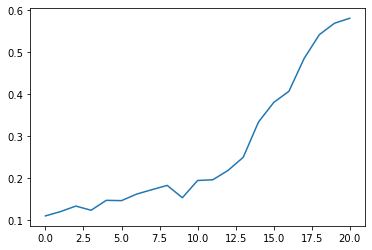

In [22]:
plt.plot(history.history['val_loss'])

### Contextual Results

In [17]:
model.load_weights('checkpoints/model_{}.h5'.format(sfreq))
print('Loaded best checkpoint!')

Loaded best checkpoint!


In [18]:
labels_test = ohe.inverse_transform(y_test).flatten()

In [19]:
pred = model.predict(X_test)

In [20]:
np.unique(labels_test)

array(['alarm-clock', 'baby-cry', 'blender', 'car-horn', 'cat-meow',
       'chopping', 'cooking', 'cough', 'dishwasher', 'dog-bark', 'door',
       'doorbell', 'drill', 'engine', 'flush', 'hair-dryer', 'hammer',
       'hazard-alarm', 'knock', 'laugh', 'microwave', 'phone-ring', 'saw',
       'shaver', 'snore', 'speech', 'toothbrush', 'typing', 'vacuum',
       'water-running'], dtype='<U32')

In [21]:
encoding = {label: ohe.transform(np.array(label).reshape(-1,1)).toarray() for label in np.unique(labels_test)}

contexts = {
    'monolithic': ['alarm-clock', 'baby-cry', 'blender', 'car-horn', 'cat-meow',
       'chopping', 'cooking', 'cough', 'dishwasher', 'dog-bark', 'door',
       'doorbell', 'drill', 'engine', 'flush', 'hair-dryer', 'hammer',
       'hazard-alarm', 'knock', 'laugh', 'microwave', 'phone-ring', 'saw',
       'shaver', 'snore', 'speech', 'toothbrush', 'typing', 'vacuum',
       'water-running'],
    'bathroom': ['water-running', 'shaver', 'toothbrush', 'flush', 'hair-dryer'],
    'kitchen': ['hazard-alarm', 'speech', 'chopping', 'water-running', 'microwave', 'blender', 'dishwasher', 'cooking'],
    'bedroom': ['speech', 'baby-cry', 'cough', 'snore', 'alarm-clock'],
    'office': ['phone-ring', 'speech', 'cough', 'door', 'knock', 'typing'],
    'entrance': ['speech', 'door', 'knock', 'doorbell', 'laugh'],
    'workshop': ['drill', 'hazard-alarm', 'speech', 'vacuum', 'hammer', 'saw'],
    'outdoor': ['dog-bark', 'hazard-alarm', 'speech', 'car-horn', 'engine', 'cat-meow']
}

context_encoding = {}
for context in contexts.keys():
    context_encoding[context] = np.zeros((1,30))
    for activity in contexts[context]:
        context_encoding[context] += encoding[activity]    

In [22]:
for context in contexts.keys():
#     context = list(contexts.keys())[0]
    valid_idx = [i for i, label in enumerate(labels_test) if label in contexts[context]]
    valid_pred = pred[valid_idx]
    valid_labels = labels_test[valid_idx]
    valid_pred = np.argmax(valid_pred * context_encoding[context], axis=1)
    valid_pred = [ohe.categories_[0][pr] for pr in valid_pred]
    acc = accuracy_score(valid_labels, valid_pred)
    f1 = f1_score(valid_labels, valid_pred, average='weighted')
    conf_mat = confusion_matrix(valid_labels, valid_pred, normalize='true')
    label_names = np.unique(valid_labels)
    print('{}, {}, {}, {}'.format(sfreq, context, acc, f1))
    # fig, ax = plt.subplots(figsize=(13,10))
    # sns.heatmap(conf_mat, cmap='Blues', ax=ax, xticklabels=label_names, yticklabels=label_names, annot=False)
    # ax.set_title('sFreq: {}, Context: {}, Acc: {}'.format(sfreq,context,acc))
    # ax.set_xlabel('Predicted Label')
    # ax.set_ylabel('True Label')

250, monolithic, 0.24025080287505735, 0.21753807234584813
250, bathroom, 0.4432389937106918, 0.3767953629978072
250, kitchen, 0.3242099322799097, 0.23509611885221973
250, bedroom, 0.27311387620097655, 0.24571837773417937
250, office, 0.3991017500387177, 0.438140046030926
250, entrance, 0.261678104936905, 0.3186410410470032
250, workshop, 0.2824427480916031, 0.2560457100237921
250, outdoor, 0.3335302806499261, 0.2292495039714536


### File-Level Metrics 

In [44]:
num_bands = 64
test_features = pickle.load(open('featurized_data/default_config/X_test_{}.pkl'.format(sfreq), 'rb'))
test_labels = pickle.load(open('featurized_data/default_config/y_test_{}.pkl'.format(sfreq), 'rb'))
# test_features = np.concatenate(np.concatenate(test_features))
# test_labels = np.concatenate(np.concatenate(test_labels))

test_features_flat = []
for cls in test_features:
    for file in cls:
        if len(file) != 0:
            test_features_flat.append(file)

test_labels_ohe = []
for cls in test_labels:
    for file in cls:
        if len(file) != 0:
            file_labels = ohe.transform(np.array(file).reshape((-1,1))).toarray()
            test_labels_ohe.append(file_labels)

NUM_CLASSES = 30

X_test = [file.reshape((-1, vggish_params.NUM_FRAMES, num_bands, 1)) for file in test_features_flat] 
y_test = [file.reshape((-1, NUM_CLASSES)) for file in test_labels_ohe]

In [48]:
model = load_model('example_model.hdf5')
model.summary()

Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 96, 64, 1)]       0         
_________________________________________________________________
conv1 (Conv2D)               (None, 96, 64, 64)        640       
_________________________________________________________________
pool1 (MaxPooling2D)         (None, 48, 32, 64)        0         
_________________________________________________________________
conv2 (Conv2D)               (None, 48, 32, 128)       73856     
_________________________________________________________________
pool2 (MaxPooling2D)         (None, 24, 16, 128)       0         
_________________________________________________________________
conv3_1 (Conv2D)             (None, 24, 16, 256)       295168    
_________________________________________________________________
conv3_2 (Conv2D)             (None, 24, 16, 256)       5900

In [24]:
model.load_weights('checkpoints/model_{}.h5'.format(sfreq))
print('Loaded best checkpoint!')

Loaded best checkpoint!


In [49]:
labels_test = np.array([ohe.inverse_transform(file).flatten() for file in y_test])

(6, 96, 64, 1)

In [50]:
pred = np.array([model.predict(file) for file in X_test])

In [ ]:
pred_time = []
for file in tqdm(X_test):
    for i in range(len(file)):
        frame = file[i:i+1]
        st = time.time()
        prediction = model.predict(frame)
        en = time.time()
        pred_time.append(en-st)

In [ ]:
print('{},{}'.format(sfreq, np.mean(pred_time)))

In [51]:
encoding = {label: ohe.transform(np.array(label).reshape(-1,1)).toarray() for label in np.unique(np.concatenate(labels_test).flatten())}

contexts = {
    'monolithic': ['alarm-clock', 'baby-cry', 'blender', 'car-horn', 'cat-meow',
       'chopping', 'cooking', 'cough', 'dishwasher', 'dog-bark', 'door',
       'doorbell', 'drill', 'engine', 'flush', 'hair-dryer', 'hammer',
       'hazard-alarm', 'knock', 'laugh', 'microwave', 'phone-ring', 'saw',
       'shaver', 'snore', 'speech', 'toothbrush', 'typing', 'vacuum',
       'water-running'],
    'bathroom': ['water-running', 'shaver', 'toothbrush', 'flush', 'hair-dryer'],
    'kitchen': ['hazard-alarm', 'speech', 'chopping', 'water-running', 'microwave', 'blender', 'dishwasher', 'cooking'],
    'bedroom': ['speech', 'baby-cry', 'cough', 'snore', 'alarm-clock'],
    'office': ['phone-ring', 'speech', 'cough', 'door', 'knock', 'typing'],
    'entrance': ['speech', 'door', 'knock', 'doorbell', 'laugh'],
    'workshop': ['drill', 'hazard-alarm', 'speech', 'vacuum', 'hammer', 'saw'],
    'outdoor': ['dog-bark', 'hazard-alarm', 'speech', 'car-horn', 'engine', 'cat-meow']
}

context_encoding = {}
for context in contexts.keys():
    context_encoding[context] = np.zeros((1,30))
    for activity in contexts[context]:
        context_encoding[context] += encoding[activity]    

In [52]:
for context in contexts.keys():
#     context = list(contexts.keys())[1]
    valid_idx = [i for i, label in enumerate(labels_test) if label[0] in contexts[context]]
    valid_pred = pred[valid_idx]
    valid_labels = labels_test[valid_idx]
    valid_pred = [np.argmax(file * context_encoding[context], axis=1) for file in valid_pred]
    # Transform to per file level labels
    valid_pred = [ohe.categories_[0][mode(file)] for file in valid_pred]
    valid_labels = [file[0] for file in valid_labels]
    acc = accuracy_score(valid_labels, valid_pred)
    f1 = f1_score(valid_labels, valid_pred, average='weighted')
    conf_mat = confusion_matrix(valid_labels, valid_pred, normalize='true')
    label_names = np.unique(valid_labels)
    print('{},{},{},{}'.format(sfreq, context, acc, f1))
    # fig, ax = plt.subplots(figsize=(13,10))
    # sns.heatmap(conf_mat, cmap='Blues', ax=ax, xticklabels=label_names, yticklabels=label_names, annot=False)
    # ax.set_title('sFreq: {}, Context: {}, Acc: {}'.format(sfreq,context,acc))
    # ax.set_xlabel('Predicted Label')
    # ax.set_ylabel('True Label')

16000,monolithic,0.004771642808452625,0.002666691038045298
16000,bathroom,0.2277580071174377,0.2320106166462348
16000,kitchen,0.075,0.06501685986190117
16000,bedroom,0.20318725099601595,0.18188358879267486
16000,office,0.15060240963855423,0.11253095377507678
16000,entrance,0.16334661354581673,0.1365843298967943
16000,workshop,0.19424460431654678,0.17420283838577771
16000,outdoor,0.12,0.06155057064147973
